In [38]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [55]:
path = f'scan5/'
# path = 'intervolume_registered/self_inter/scan5/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.h5'):
        pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'][:,150:650,:])

# original_data = original_data[:,150:650,:]

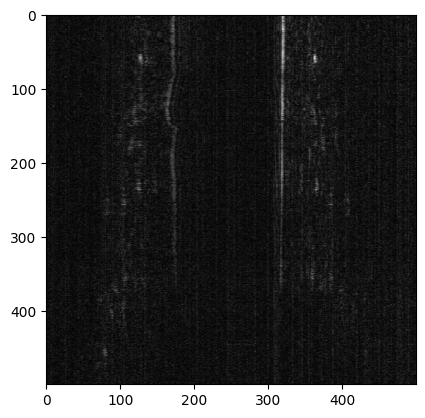

In [56]:
plt.imshow(original_data[:,:,10],cmap='gray')

In [41]:
y_err_ncc = []
UP,DOWN = 140,210
for i in tqdm(range(original_data.shape[0])):
    y_err_ncc.append(ncc(original_data[i][UP:DOWN],original_data[200][UP:DOWN])[0])
print(np.mean(y_err_ncc[2:-2]))

100%|██████████| 500/500 [00:00<00:00, 10988.08it/s]

0.7746011255382822


# FLat

In [24]:
mid = 250
flat_err_ncc = []
UP,DOWN = 140,210
for i in tqdm(range(original_data.shape[2])):
    flat_err_ncc.append(ncc(original_data[:,:mid,i],original_data[:,:mid,372])[0])
print(np.mean(flat_err_ncc[2:-2]))

100%|██████████| 417/417 [00:00<00:00, 452.98it/s]

0.7719332962195837


In [25]:

def mse_fun_tran_flat(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=1)
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=1)

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=1)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=1)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_tran_flat(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[2],1,1))
    for i in tqdm(range(data.shape[2]),desc='tr_all'):
        stat = data[:,UP:DOWN,372][::20].copy()
        temp_img = data[:,UP:DOWN,i][::20].copy()

        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran_flat,x0 =(0), bounds=[(-3,3)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(translation=(past_shift*2,0))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)

    return transforms_all


In [26]:
n = original_data.shape[1]

# finding the bright points in all images in standard interference
temp_rotated_data = original_data[:,:n//2,:].transpose(2,1,0)
nn = [np.argmax(np.sum(temp_rotated_data[i],axis=1)) for i in range(temp_rotated_data.shape[0])]
tf_all_nn = np.tile(np.eye(3),(temp_rotated_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(-(nn[0]-nn[i]),0)))
for i in tqdm(range(original_data.shape[2]),desc='warping'):
    original_data[:,:mid,i]  = warp(original_data[:,:mid,i] ,AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 417/417 [00:02<00:00, 142.15it/s]


In [27]:
UP,DOWN = 140,210
tr_all = ants_all_tran_flat(original_data,UP,DOWN)
for i in tqdm(range(original_data.shape[2]),desc='warping'):
    original_data[:,:mid,i]  = warp(original_data[:,:mid,i] ,AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 417/417 [00:03<00:00, 138.82it/s]


In [28]:
flat_err_ncc = []
for i in tqdm(range(original_data.shape[2])):
    flat_err_ncc.append(ncc(original_data[:,:mid,i],original_data[:,:mid,372])[0])
print(np.mean(flat_err_ncc[2:-2]))

100%|██████████| 417/417 [00:00<00:00, 489.07it/s]

0.7018873767805645


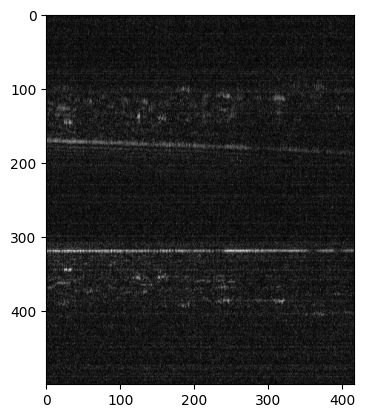

In [33]:
plt.imshow(original_data[10,:,:],cmap='gray')

# Y-motion

In [57]:
np.argmax(np.sum(original_data[:,UP:DOWN,:],axis=(1,2)))

np.int64(127)

In [58]:

def mse_fun_tran(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(0,-past_shift)),order=3)
    y = warp(y, AffineTransform(translation=(0,past_shift)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(0,-shif[0])),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(0,shif[0])),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        stat = data[127][UP:DOWN][:,::20].copy()
        temp_img = data[i][UP:DOWN][:,::20].copy()
        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        past_shift = 0
        for _ in range(10):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0), bounds=[(-2,2)],
                        args = (stat
                                ,temp_img
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(0,past_shift*2)))
        transforms_all[i] = np.dot(transforms_all[i],temp_tform_manual)
    return transforms_all


In [59]:
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 217.46it/s]


In [60]:

tr_all = ants_all_trans(original_data,UP,DOWN)
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 198.76it/s]


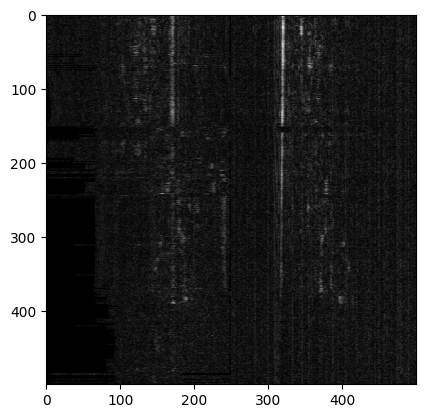

: 

In [ ]:
plt.imshow(original_data[:,:,30],cmap='gray')